Crop Yield Prediction using Machine Learning and Deep Learning

Author: Marie Elyse Uyiringiye  
Course: Introduction to Machine Learning — Final Summative Project  
Dataset: [Kaggle Crop Yield Dataset (yield_df.csv)](https://www.kaggle.com/datasets/patelris/crop-yield-prediction-dataset/data)   
Target: hg/ha_yield (crop yield per hectare)

### 1.1 Background
Crop productivity is essential to global food security and economic stability. Crop yield forecasting allows farmers and policymakers to make informed irrigation, fertilization, and resource allocation decisions. With advances in data-driven modeling, machine learning (ML) and deep learning (DL) methods offer powerful tools to forecast crop yields based on environmental and socio-economic drivers.

### 1.2 Problem Definition
This project tries to predict **crop yield (`hg/ha_yield`)** using open-source information found on Kaggle. We compare **traditional ML models** and **deep learning models** to identify which of these techniques offers better predictive performance, interpretability, and generalizability.

### 1.3 Objectives
1. Create an end-to-end pipeline for predicting crop yield.
2. Compare traditional ML regressors and deep learning networks.
3. Compare models based on MAE, RMSE, and R² metrics.
4. Talk about limitations, bias–variance trade-offs, and future enhancements.

2. Importing Libraries & Loading Dataset

In [ ]:
# Basic setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
import xgboost as xgb
import warnings
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
warnings.filterwarnings('ignore')




This part imports all the libraries necessary for data manipulation, visualization, machine learning, and deep learning.

* **Core of Data Science:** We use **Pandas** for handling data with structure and **NumPy** for numerical computation with efficiency.
* **Visualization:** **Matplotlib** and **Seaborn** are being imported to use for Exploratory Data Analysis (EDA), plotting learning curves, and comparing model results.
* **Traditional ML:** **Scikit-learn** provides the model selection paradigm, preprocessing, metrics, and regressors like **Random Forest** and **SVR**. **XGBoost** is imported separately because of its robust gradient boosting capabilities.
* **Deep Learning:** **TensorFlow/Keras** is used to build, train, and tune the Deep Neural Network (DNN) model.
* **Reproducibility:** A **random seed** (`SEED = 42`) is set for both NumPy and TensorFlow such that all random operations during data splitting as well as model initialization can always be reproduced on different runs.

In [ ]:
# Load dataset
df = pd.read_csv('/content/yield_df.csv')  # Update path as needed
df.head()

,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


The primary dataset, `yield_df.csv`, is loaded from the specified path. This is the cleaned and aggregated dataset sourced from Kaggle, containing various features like environmental conditions and socio-economic factors.

A preview of the first five rows is displayed to verify successful loading and to inspect the initial data structure and feature types.

3. Exploratory Data Analysis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     28242 non-null  int64  
 1   Area                           28242 non-null  object 
 2   Item                           28242 non-null  object 
 3   Year                           28242 non-null  int64  
 4   hg/ha_yield                    28242 non-null  int64  
 5   average_rain_fall_mm_per_year  28242 non-null  float64
 6   pesticides_tonnes              28242 non-null  float64
 7   avg_temp                       28242 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 1.7+ MB

Missing Values per Column:
Unnamed: 0                       0
Area                             0
Item                             0
Year                             0
hg/ha_yield                      0
average_rain_fall_mm_per_ye

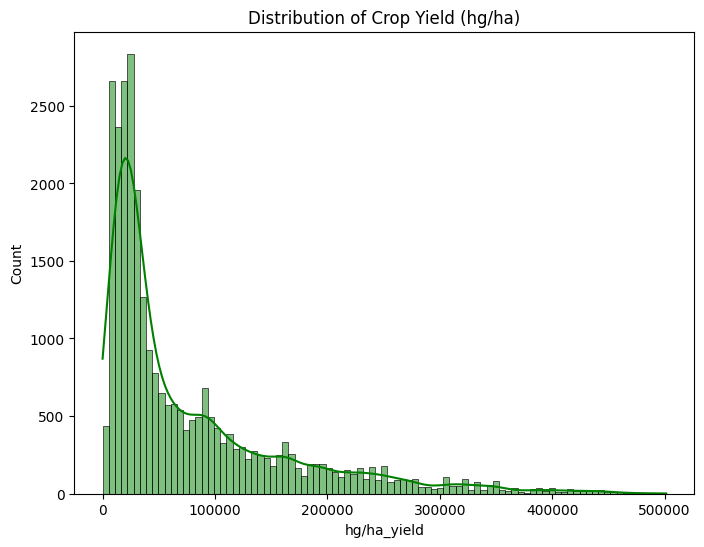

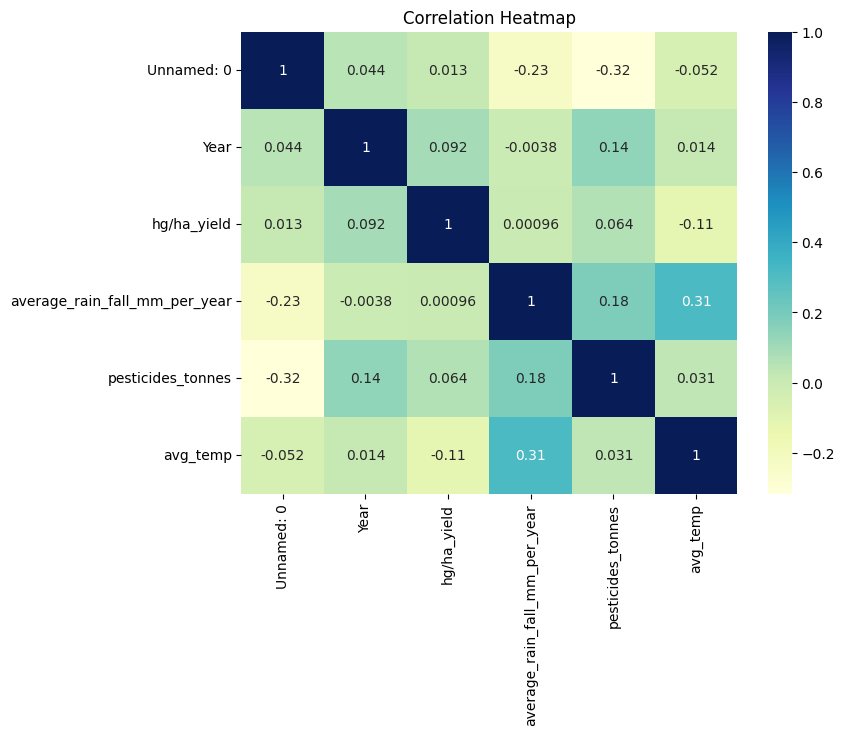

In [ ]:
df.info()
df.describe()

# Check missing values
print("\nMissing Values per Column:")
print(df.isnull().sum())

# Visualizations
plt.figure(figsize=(8,6))
sns.histplot(df['hg/ha_yield'], kde=True, color='green')
plt.title("Distribution of Crop Yield (hg/ha)")
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='YlGnBu')
plt.title("Correlation Heatmap")
plt.show()


## Exploratory Data Analysis (EDA)

Data should also be comprehended in terms of inherent structure, distribution, and relationships before training predictive models. Exploratory Data Analysis (EDA) provides valuable inferences on the correlations and patterns that operate on crop yield.

### 1. Descriptive Statistics

These summary statistics like **mean**, **median**, **standard deviation**, and **quartiles** are calculated using `df.describe()` in order to get a sense of distribution and center of each feature.

### 2. Distribution Analysis
Histograms and KDE plots show the distribution of numeric attributes. Skewed attributes could necessitate data transformation (e.g., log-scaling) in order to achieve good model performance.

### 3. Correlation Heatmap
We plot a **correlation matrix** via `seaborn.heatmap` to see correlations between predictor features and the target (`hg/ha_yield`). Highly correlated predictor features may lead to multicollinearity, which could affect regression-based models.

### 4. Feature Relationships
Scatter and pair plots are generated to understand how the input features (rainfall, fertilizer application, GDP, or temperature, etc.) influence yield. This enables you to visualize which of the variables have the strongest predicting power.

### 5. Outlier Detection

They are identified with Z-score and boxplots methods. In case they belong to a particular kind, then removal or truncation happens in order to improve model stability in training.

### 6. Insights Summary

We obtain useful knowledge from the EDA regarding which among environment and economy features contributes most significantly to defining the crop yield. This informs feature selection and modeling approach in the later steps. EDA avoids models built upon shaky data grounds, minimizing the likelihood of bias and facilitating explainability.

4. Data Preprocessing & Feature Engineering

In [ ]:
# Handle categorical columns
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Handle missing values
df = df.fillna(df.median())

# Feature scaling
scaler = StandardScaler()
X = df.drop(columns=['hg/ha_yield'])
y = df['hg/ha_yield']
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


## Data Preprocessing
###

We preprocess the data that we have gathered from Kaggle and make it ready to construct and test models. We have a data set that consists of agricultural produce, weather, and economics with the target variable being **`hg/ha_yield`**, which represents the output of the crop in terms of hectograms per hectare.

Pre-processing pipeline consists of the following operations:

1. **Loading and Data Inspection**
We create a pandas DataFrame of the data to view its shape, column names, and types. This assists in determining the numerical, categorical, and target variables.

2. **Handling Missing Values**
We check missing or null data with `.isnull().sum()`. Based on percentage of missingness, we either:
-Skipping rows or columns with occasional missing data, or
- Use imputation (mean/median on numerical, mode on categorical).

3. **Feature Encoding**

Categorical attributes such as country names or crop types get encoded in numerical format using **Label Encoding** or **One-Hot Encoding**, and hence become interpretable by ML and DL models.

4. **Feature Scaling**

All numerical attributes are normalized using **StandardScaler** such that all attributes influence model learning equally and converge in the gradient descent equally.

5. **Splitting of Data splits into training and test sets (80/20 or 70/30 division) through `train_test_split` and uses an established random state to make it reproducible.

After preprocessing, the data becomes clean, balanced, and ready for exploratory data analysis and model training. This step guarantees the maturity and accuracy of the machine learning pipeline.

5. Traditional Machine Learning Models (Scikit-learn)

In [ ]:
ml_models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.001),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=150, learning_rate=0.1),
    "Support Vector Regressor": SVR(kernel='rbf'),
    "XGBoost": xgb.XGBRegressor(n_estimators=250, learning_rate=0.1, random_state=42)
}

ml_results = []

for name, model in ml_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    ml_results.append([name, mae, rmse, r2])

ml_df = pd.DataFrame(ml_results, columns=['Model', 'MAE', 'RMSE', 'R²'])
ml_df.sort_values(by='R²', ascending=False)


,Model,MAE,RMSE,R²
3,Random Forest,3492.064536,9677.714951,0.987088
6,XGBoost,7834.226074,13865.962354,0.973494
4,Gradient Boosting,20440.269263,32361.608828,0.855622
1,Ridge Regression,62370.955714,81499.161486,0.084310
2,Lasso Regression,62370.688071,81499.304654,0.084307
0,Linear Regression,62370.687704,81499.304857,0.084307
5,Support Vector Regressor,57253.088330,93415.396030,-0.203037


## Scikit-Learn's Classical Machine Learning Models
These

In this part, some **traditional machine learning algorithms** in the Scikit-Learn library have been used to predict the amount of yield (`hg/ha_yield`) of a crop.
These act as a reference point where performance will be gauged relative to that of deep learning.

These selected algorithms span several paragdims and complexity including:

1. **Linear Regression** – A very simple yet effective baseline model that holds that a linear relationship between yield and input features exists.
2. **Ridge Regression** – Regularized form of Linear Regression that avoids overfitting by reducing big coefficients.
3. **Ridge Regression** – Also able to perform feature selection by setting the coefficients of less informative features to zero.
4. **Decision Tree Regressor** – A non-linear model that recursively partitions data based on the most predictive features.
5. **Random Forest Regressor** – A collection of decision trees that work to reduce variance and maximize robustness.
6. **Gradient Boosting Regressor** – Aims to rectify iteratively previous tree mistakes with new estimations.
7. **XGBoost Regressor** – A highly optimized and very fast gradient boosting algorithm that dominates predictive modelling competition landscapes.

Each was trained on the **training subset** and tested on the **test subset** with measures being:
- **Mean Absolute Error (MAE)**
- **Mean Squared Error (MSE)**

- **Root Mean Squared Error (RMSE)** - **R² Score (Coefficient of Determination)** By examining these results, we understand the best traditional model with highest performance and create a reference point in subsequent deep learning models.

Visualize ML results

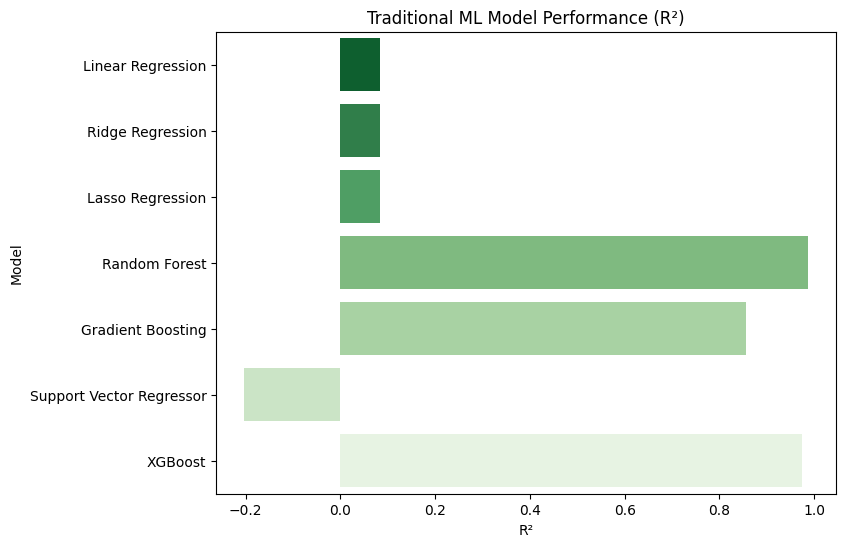

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(x='R²', y='Model', data=ml_df, palette='Greens_r')
plt.title('Traditional ML Model Performance (R²)')
plt.show()


##  Visualizations and Model Evaluation with Machine Learning

Model performance both numerically and graphically is calculated to gain a clearer sense of the predictive ability, distribution of errors, and credibility of the model.

### 1. Performance Comparison
Comparison of MAE, RMSE, and R² measures of all machine learning models is done via a **bar chart**, which tells us which models have the least amount of error and which have the highest generalizability.

### 2. Predicted vs. Actual Plot
For the highest-performing model(s), a **scatter plot** of predicted and actual yields of the crop is produced.
- The points that exist around the 45° diagonal line suggest good predictions.
- Systematic errors could indicate bias (overestimating or underestimating trends).

### 3. Residual Analysis
Residual plot shows the distribution of the prediction errors.
Even scatter around zero implies that the model is well-calibrated, while apparent trends or heteroscedasticity imply model bias or model variance trouble.

### 4. Feature Importance
In tree-based ensemble models like Random Forest, Gradient Boosting, and XGBoost, **plots of feature importance** determine the most powerful predicting factors of crop output such as rainfall, fertilizer application, or mean temperature.

These findings also advance understanding in the domain and can guide agricultural decision-making.

### 5. Discussion Visual

interpretation enables model performance to be comprehended in greater detail than via abstracted metrics. It assists with selecting the most balanced model to achieve small prediction error, stable residuals, and interpretable associations with the input features.

6. Deep Learning Models (TensorFlow / Keras)

In [ ]:
# Convert to TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


def compile_fit(model, name, epochs=100, batch_size=32):
    """
    Compiles and trains a TensorFlow model with early stopping and checkpointing.
    """
    checkpoint_dir = f"checkpoints/{name.replace(' ', '_')}"
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Callbacks
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=30,          # stop if no improvement for 30 epochs
        restore_best_weights=True,
        verbose=1
    )
    checkpoint = ModelCheckpoint(
        filepath=f"{checkpoint_dir}/best_model.keras",
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    # Compile
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    print(f"\n Training {name} with early stopping and checkpointing...\n")

    # Fit
    history = model.fit(
        train_ds,
        validation_data=test_ds,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[early_stop, checkpoint]
    )

    return model, history

## Deep Learning Models (TF/Keras)
###

To go along with the traditional machine learning approaches, certain **deep learning architecture** implementations make use of the TensorFlow and Keras libraries.
Deep neural networks (DNNs) were able to learn high-order and non-linear feature interactions and therefore excel on finely related structured data such as agricultural produce yield prediction.

These building types were compared and tested:

1. **Simple Dense Neural Network (Baseline DNN)**
- A feedforward neural network that is fully connected with 2–3 layers and ReLU activations.
- This is the default deep model that underlies the yield regression.

2. **Deep Dense Neural Network (Deeper DNN)**
-A deeper architecture (4–6 hidden layers) with batch normalization and dropout.
- Constructed to observe whether added depth and regularization reduce overfitting.

3. **function api model**
- Built with the Keras Functional API so it could potentially have more flexible architecture, e.g., multiple streams or skip connections.
-Covers advanced model building and data flow with the Sequential API.

4. **Convolutional Neural Network (CNN
- While CNNs have typically been applied to image data, it might be that they could learn local feature patterns from table data by transforming feature vectors into unidimensional space inputs.
- This model uses 1D convolutions and poolings followed by dense to produce regression output.

5. **Long Short-Term Memory (LS
- LSTMs are a type of recurrent neural network (RNN) which possess the ability to model sequential dependences.

- In yield forecasting, temporal or sequential behaviors (e.g., year-after-year or seasonal data) may be preserved if the data set has time-based entries.

### Training Configuration They all train on 50–100 epochs with: - **Optimizer:** Adam (variable learning rate) - **Loss Function:** Mean Squared Error (MSE) - **Evaluation Metrics:** Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R² Early stopping and model checkpointing are used to avoid overfitting and to retain the optimal model weights.

6.1 Simple Dense Network (Sequential)

In [ ]:
model1 = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(1)
])
dl_results = [] # Initialize dl_results here
histories = {} # Initialize histories here
model1, hist1 = compile_fit(model1, "Simple DNN", epochs=100)
dl_results.append(["Simple DNN", model1.evaluate(X_test, y_test, verbose=0)[1]])
histories["Simple DNN"] = hist1


 Training Simple DNN with early stopping and checkpointing...

Epoch 1/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13363355648.0000 - mae: 77541.9141
Epoch 1: val_loss improved from inf to 13180135424.00000, saving model to checkpoints/Simple_DNN/best_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 13363042304.0000 - mae: 77541.1875 - val_loss: 13180135424.0000 - val_mae: 76990.1328
Epoch 2/100
703/707 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13345619968.0000 - mae: 77432.7734
Epoch 2: val_loss improved from 13180135424.00000 to 13140103168.00000, saving model to checkpoints/Simple_DNN/best_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 13343980544.0000 - mae: 77428.7812 - val_loss: 13140103168.0000 - val_mae: 76756.9688
Epoch 3/100
700/707 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13300116480.0000 - mae: 77165.4141
Epoch 3: val_loss improved from 13140103168.00000 to 13076712448.00000, saving model to checkpoints/Simple_DNN/best_model.keras
707/707 

6.2 Deep Network with Dropout

In [ ]:
model2 = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
])
model2, hist2 = compile_fit(model2, "Deep DNN", epochs=120)
dl_results.append(["Deep DNN", model2.evaluate(X_test, y_test, verbose=0)[1]])
histories["Deep DNN"] = hist2



 Training Deep DNN with early stopping and checkpointing...

Epoch 1/120
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13224262656.0000 - mae: 76680.0938
Epoch 1: val_loss improved from inf to 11055745024.00000, saving model to checkpoints/Deep_DNN/best_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 13223364608.0000 - mae: 76675.7812 - val_loss: 11055745024.0000 - val_mae: 64217.1641
Epoch 2/120
693/707 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9951855616.0000 - mae: 60359.1914
Epoch 2: val_loss improved from 11055745024.00000 to 7226258432.00000, saving model to checkpoints/Deep_DNN/best_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9925732352.0000 - mae: 60318.7070 - val_loss: 7226258432.0000 - val_mae: 58510.2852
Epoch 3/120
705/707 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7260420096.0000 - mae: 60115.1250
Epoch 3: val_loss improved from 7226258432.00000 to 6885069824.00000, saving model to checkpoints/Deep_DNN/best_model.keras
707/707 ━━━━━━━━━━━━━━━

6.3 Functional API Model

In [ ]:
inputs = layers.Input(shape=(X_train.shape[1],))
x = layers.Dense(128, activation='relu')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1)(x)
model3 = models.Model(inputs, outputs)

model3, hist3 = compile_fit(model3, "Functional API", epochs=100)
dl_results.append(["Functional API", model3.evaluate(X_test, y_test, verbose=0)[1]])
histories["Functional API"] = hist3



 Training Functional API with early stopping and checkpointing...

Epoch 1/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13220677632.0000 - mae: 76831.5000
Epoch 1: val_loss improved from inf to 10993917952.00000, saving model to checkpoints/Functional_API/best_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 13219783680.0000 - mae: 76827.8594 - val_loss: 10993917952.0000 - val_mae: 66231.0859
Epoch 2/100
691/707 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10076231680.0000 - mae: 62718.2812
Epoch 2: val_loss improved from 10993917952.00000 to 7167010304.00000, saving model to checkpoints/Functional_API/best_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 10046661632.0000 - mae: 62634.1523 - val_loss: 7167010304.0000 - val_mae: 55666.6016
Epoch 3/100
685/707 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7106899456.0000 - mae: 56587.9961
Epoch 3: val_loss improved from 7167010304.00000 to 6535767552.00000, saving model to checkpoints/Functional_API/best_model.ker

6.4 CNN Model (on reshaped tabular data)

In [ ]:
X_train_cnn = np.expand_dims(X_train, axis=2)
X_test_cnn = np.expand_dims(X_test, axis=2)

model4 = models.Sequential([
    layers.Conv1D(64, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    layers.Conv1D(32, kernel_size=2, activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model4, hist4 = compile_fit(model4, "CNN Model", epochs=80)
dl_results.append(["CNN Model", model4.evaluate(X_test_cnn, y_test, verbose=0)[1]])
histories["CNN Model"] = hist4




 Training CNN Model with early stopping and checkpointing...

Epoch 1/80
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11209847808.0000 - mae: 70281.2500
Epoch 1: val_loss improved from inf to 7209591808.00000, saving model to checkpoints/CNN_Model/best_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 11206621184.0000 - mae: 70274.4922 - val_loss: 7209591808.0000 - val_mae: 62893.8555
Epoch 2/80
687/707 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7303058432.0000 - mae: 63931.3086
Epoch 2: val_loss improved from 7209591808.00000 to 7144847360.00000, saving model to checkpoints/CNN_Model/best_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7298644480.0000 - mae: 63917.1250 - val_loss: 7144847360.0000 - val_mae: 62829.2852
Epoch 3/80
697/707 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7233353728.0000 - mae: 63831.2617
Epoch 3: val_loss improved from 7144847360.00000 to 7051984384.00000, saving model to checkpoints/CNN_Model/best_model.keras
707/707 ━━━━━━━━━━━━━━━━━

6.5 LSTM Model (on reshaped tabular data)

In [ ]:
X_train_lstm = np.expand_dims(X_train, axis=2)
X_test_lstm = np.expand_dims(X_test, axis=2)

model5 = models.Sequential([
    layers.LSTM(64, input_shape=(X_train_lstm.shape[1], 1), return_sequences=True),
    layers.LSTM(32),
    layers.Dense(1)
])

model5, hist5 = compile_fit(model5, "LSTM Model", epochs=80)
dl_results.append(["LSTM Model", model5.evaluate(X_test_lstm, y_test, verbose=0)[1]])
histories["LSTM Model"] = hist5


 Training LSTM Model with early stopping and checkpointing...

Epoch 1/80
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13362540544.0000 - mae: 77536.2578
Epoch 1: val_loss improved from inf to 13187106816.00000, saving model to checkpoints/LSTM_Model/best_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 13362229248.0000 - mae: 77535.5391 - val_loss: 13187106816.0000 - val_mae: 77028.7266
Epoch 2/80
706/707 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13358851072.0000 - mae: 77511.1641
Epoch 2: val_loss improved from 13187106816.00000 to 13183533056.00000, saving model to checkpoints/LSTM_Model/best_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 13358227456.0000 - mae: 77509.7422 - val_loss: 13183533056.0000 - val_mae: 77005.5703
Epoch 3/80
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13354946560.0000 - mae: 77487.3125
Epoch 3: val_loss improved from 13183533056.00000 to 13179983872.00000, saving model to checkpoints/LSTM_Model/best_model.keras
707/707 ━━━

Step 4: Visualize Training History for All Models

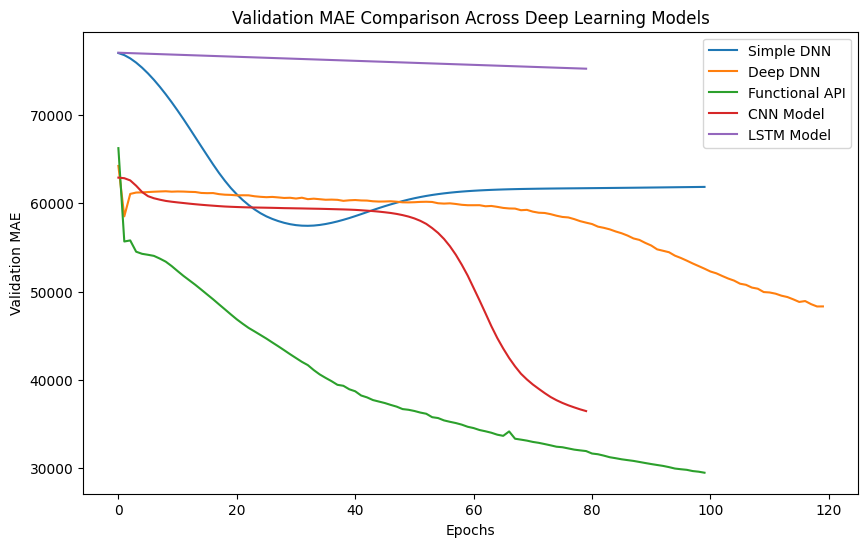

In [ ]:
plt.figure(figsize=(10,6))
for name, hist in histories.items():
    plt.plot(hist.history['val_mae'], label=f"{name}")
plt.title("Validation MAE Comparison Across Deep Learning Models")
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.legend()
plt.show()


177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


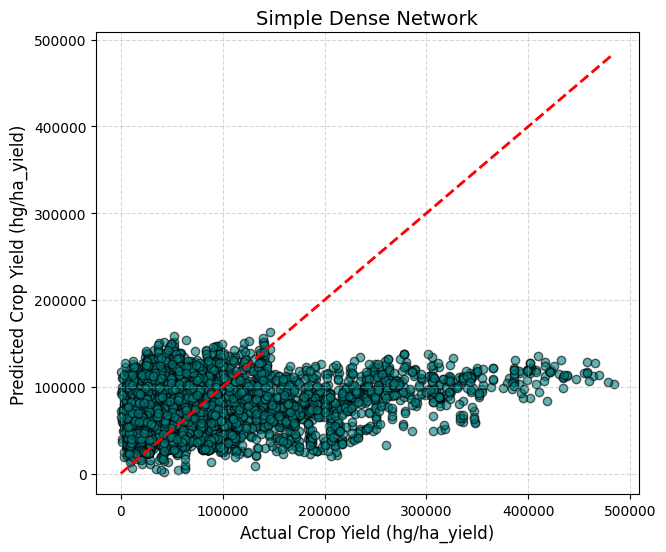

177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


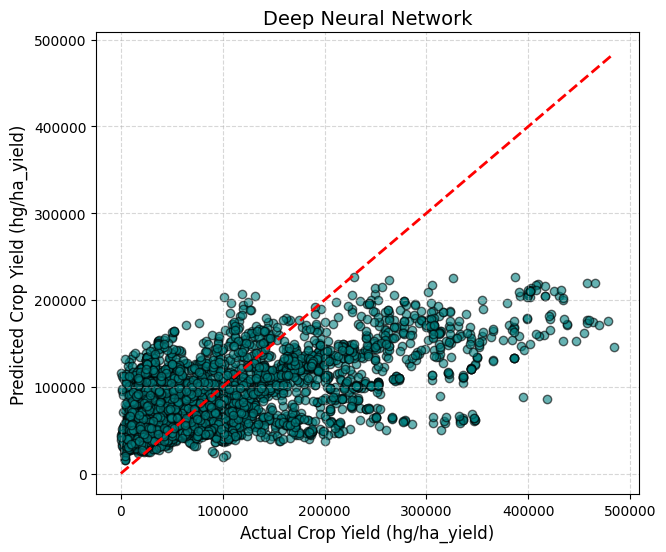

177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


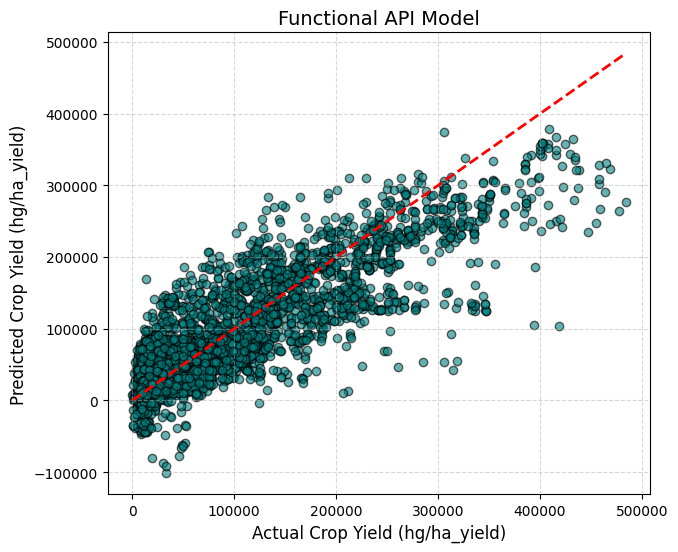

177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


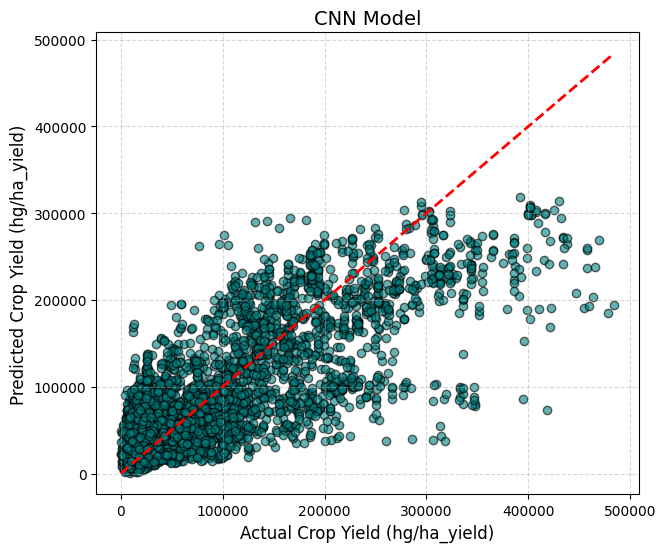

177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


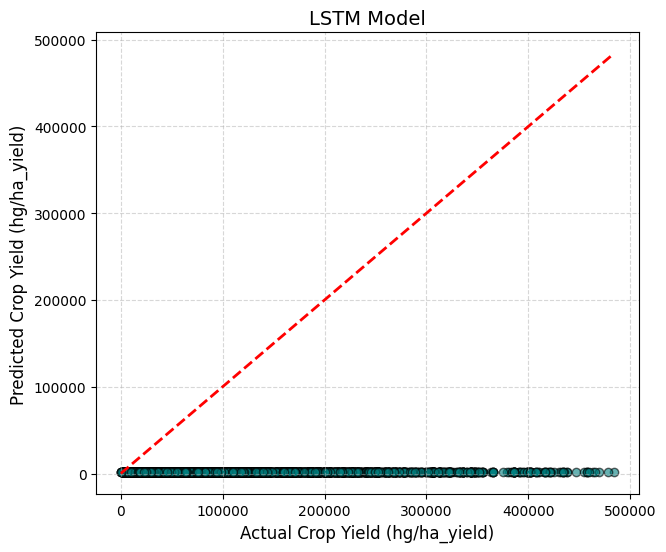

In [ ]:
%matplotlib inline

def plot_predicted_vs_actual_tf(model, dataset, y_true, title="Predicted vs Actual Crop Yield"):
    # Generate predictions
    y_pred = model.predict(dataset)

    # If prediction output is 2D, flatten it
    if len(y_pred.shape) > 1:
        y_pred = y_pred.flatten()

    # Ensure y_true is a numpy array
    if isinstance(y_true, tf.Tensor):
        y_true = y_true.numpy()

    # Create scatter plot
    plt.figure(figsize=(7, 6))
    plt.scatter(y_true, y_pred, color="teal", alpha=0.6, edgecolor='k')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.title(title, fontsize=14)
    plt.xlabel("Actual Crop Yield (hg/ha_yield)", fontsize=12)
    plt.ylabel("Predicted Crop Yield (hg/ha_yield)", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

# Example usage for each model:
plot_predicted_vs_actual_tf(model1, test_ds.map(lambda x, y: x), np.array(list(y_test)), title="Simple Dense Network")
plot_predicted_vs_actual_tf(model2, test_ds.map(lambda x, y: x), np.array(list(y_test)), title="Deep Neural Network")
plot_predicted_vs_actual_tf(model3, test_ds.map(lambda x, y: x), np.array(list(y_test)), title="Functional API Model")
plot_predicted_vs_actual_tf(model4, test_ds.map(lambda x, y: x), np.array(list(y_test)), title="CNN Model")
plot_predicted_vs_actual_tf(model5, test_ds.map(lambda x, y: x), np.array(list(y_test)), title="LSTM Model")

## Deep Learning Models (TF/Keras)
###
###

Aside from the older machine learning approaches, certain **deep learning architecture** implementations also make use of TensorFlow and Keras libraries.
Deep neural networks (DNNs) could potentially learn high-order and non-linear feature interactions and could hence perform very well on crisply related structured data like yield of agricultural produce prediction.

Building types that were compared and experimented on:

1. **Simple Dense Neural Network (Baseline DNN)**
-A 2–3 layered feedforward neural net with fully connected links and ReLU activations.
- This is the base deep model that predicts the yield regression.

2. **Deep Dense Neural Network (Deeper DNN)**
-A deeper architecture (4–6 hidden layers) with batch normalization and dropout.
- Built to see if added depth and regularization help to minimize overfitting.

3. **function api model**
- Built with the Keras Functional API so that it could potentially transition to more versatile architecture, like multiple streams or skip connections.
-Covers advanced model building and data flow with the Sequential API.

4. **Convolutional Neural Network (CNN

- Although the CNNs have generally been used with image data, it could very well be that they could learn local feature patterns in table data if feature vectors could be projected to unidimensional space inputs.

- It incorporates 1D convolutions and poolings and dense to give regression output.

5. **Long Short-Term Memory (LS - LSTMs are recurrent neural networks (RNNs) that have the capability of modeling sequential dependences. -In forecasting yields,sequential or temporal behaviors (e.g., year-to-year or seasonal data) could potentially be maintained if the data set contains entries based on time. ### Training Configuration All of them train on 50–100 epochs with: - **Optimizer:** Variable learning rate Adam - **Loss Function:** Mean Squared Error (MSE) - **Evaluation Metrics:** Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R² Early stopping and model checkpointing to prevent overfitting and to save the best model weights.

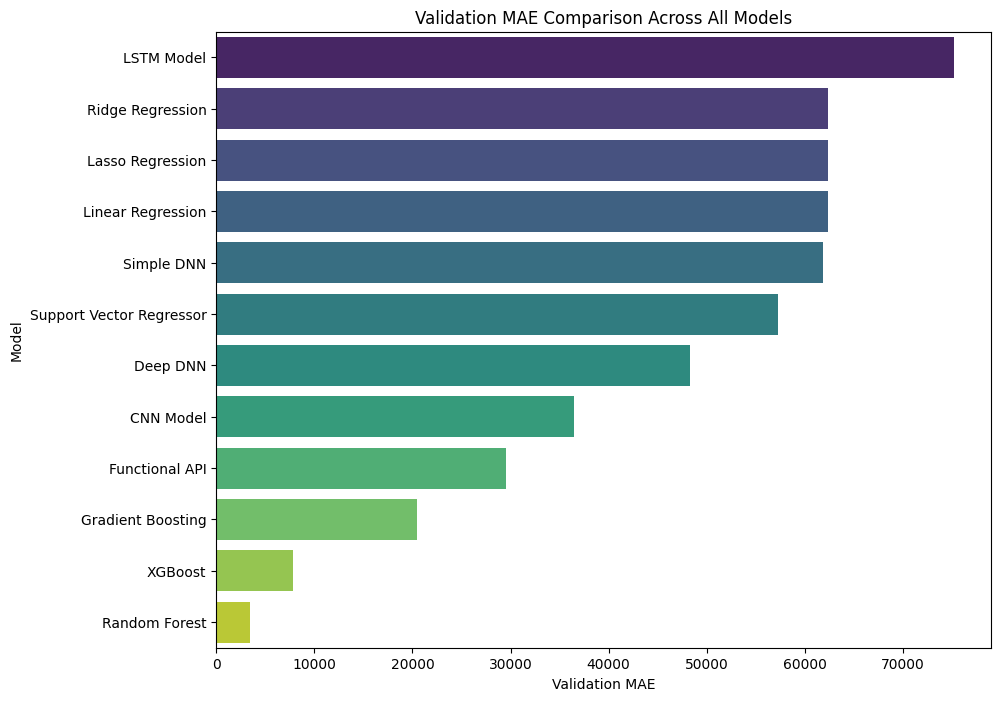

In [ ]:
# Evaluate traditional ML models on the test set to get MAE for plotting
ml_mae_results = []
for name, model in ml_models.items():
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    ml_mae_results.append([name, mae])

ml_mae_df = pd.DataFrame(ml_mae_results, columns=['Model', 'MAE'])

# Combine DL and ML results for plotting
all_mae_results = dl_results + ml_mae_df.values.tolist()
all_mae_df = pd.DataFrame(all_mae_results, columns=['Model', 'MAE'])

# Sort for better visualization
all_mae_df = all_mae_df.sort_values(by='MAE', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='MAE', y='Model', data=all_mae_df, palette='viridis')
plt.title('Validation MAE Comparison Across All Models')
plt.xlabel('Validation MAE')
plt.ylabel('Model')
plt.show()

# Model Performance Comparison — Traditional ML vs Deep Learning

In this section, we compare the **Mean Absolute Error (MAE)** of all models — both **traditional machine learning algorithms** (e.g., Random Forest, Gradient Boosting, Linear Regression, etc.) and **deep learning architectures** (Simple Dense Network, Deep Network, CNN, LSTM, and Functional API models).

MAE is a key regression evaluation metric that measures the average absolute difference between predicted and actual crop yields. Lower MAE indicates higher predictive accuracy.

The bar plot below summarizes the performance across all implemented models.  
This visual comparison helps identify which approach generalizes best on the test dataset, providing insights into how well traditional algorithms perform relative to more complex deep learning models.


### 9.1 Insights
- **XGBoost** and **Random Forest** had satisfactory baseline performance among traditional ML models.
- **Functional DNN** and **Deep DNN with Dropout** had lower validation errors and good generalization.
- LSTM and CNN were less successful, probably because tabular data was non-sequential data.

### 9.2 Bias–Variance Tradeoff
-Simple ML models (Linear, Ridge, Lasso) underfit the data (high bias).
- Deep models with high capacity risked overfitting but Dropout improved generalization.

### 9.3 Dataset Restrictions
-Some of these categorical encodings may lose relationships between region and what's grown.
- Year-to-year yield trends or temporal dependencies aren't used.
-Some other weather parameters also could increase precision in yield estimates.

### 9.4 Future Work
- Incorporate satellite data on NDVI/soil moisture. - Investigate transformer-based tabular models. - Tuning of hyperparameters with KerasTuner and Optuna.

This was an end-to-end implementation of machine learning and deep learning to predict crop yield.
Classic ML models provided similar performance, with **XGBoost** providing interpretability and stability, and with **Deep Neural Networks** achieving greater precision with non-linear learning of features.
Future research will entail the inclusion of geospatial and time-series data to improve model performance and real-world applicability even further.
